# A notebook to test images using AlexNet and calculate their cosine similarity at image space or feature space

Image information under the folder 'data':
    set1: 10,000 low-noise images with orientBW = 3, centerFreq = 0, freqSigma = 10; 
          mean orientation for each was randomly generated (rand(1,10,000)*180) and stored in 'actual_orient.mat'
          
    set2: low noise, 180 subfolders, each with a perticular angle (0:1:179), 
          orientBW = 3; centerFreq = 0; freqSigma = 10; 
          
    set3: same parameters as set2
    
    set4: same parameters as set2
    
    set5: same parameters as set2
    
    set6: same parameters as set2
    
    set11: high noise, 180 subfolders, each with a perticular angle, 
           orientBW = 15; centerFreq = 0; freqSigma = 10; 
           
    set12: same parameters as set11
    
    set13: same parameters as set11
    
    set14: same parameters as set11
    
    set15: same parameters as set11
    
    set21: 1/f spatial frequency, low orientation noise
    
    set31: 1/f spatial frequency, high orientation noise
    
    set41 (also _val): gaussian spatial freq, multiple orientation noise levels, used to fine tune a model less sensitive to the actual external noise level. 
    
    set51 (also_val): gaussian spatial freq (centerFreq = 0; freqSigma = 10), low noise orientation stim (orientBW = .5), to fine tune a model to perform orientation estimation task

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable
from torch import nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json, string
%matplotlib inline

# 1. Define the appropriate image pre-processing function.
preprocessFn = transforms.Compose([transforms.Scale(256), 
                                   transforms.CenterCrop(224), 
                                   transforms.ToTensor(), 
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])
# normalized with a specific mean and standard deviation


/Users/cqiu/anaconda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [2]:
# 2. load AlexNet
alexnet = models.alexnet(pretrained = True)

# 3. Forward a test image of the toaster.
# Never forget to set in evaluation mode so Dropoff layers don't add randomness (not active).
alexnet.eval()
# unsqueeze(0) adds a dummy batch dimension which is required for all models in pytorch.
image1 = Image.open('data/set2/ang_000/img_ind_03.png').convert('RGB')
inputVar1 = Variable(preprocessFn(image1).unsqueeze(0))
features1 = alexnet.features(inputVar1)

In [3]:
ang_ind = 10
img_ind = 2
image2 = Image.open('data/set2/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%img_ind + '.png').convert('RGB')
inputVar2 = Variable(preprocessFn(image2).unsqueeze(0))
features2 = alexnet.features(inputVar2)

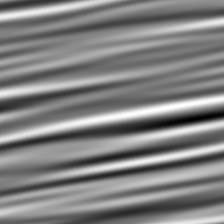

In [4]:
image2

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(
    features1.data.numpy().reshape(1, -1),
    features2.data.numpy().reshape(1, -1)
)

array([[0.72845894]], dtype=float32)

3.3748159408569336
0.7257715451717377


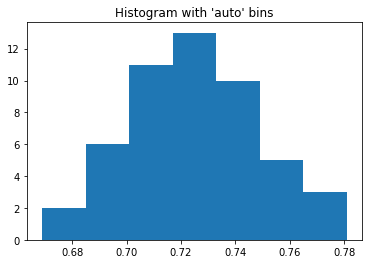

In [6]:
import time
# use the feature vector, alexnet.features
ang1_ind = 20
ang2_ind = 45
cosSimilarity = np.empty((50,1,))
t1 = time.time()
for img_ind in np.arange(50):
    # load the 1st image
    image1 = Image.open('data/set2/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    inputVar1 = Variable(preprocessFn(image1).unsqueeze(0))
    features1 = alexnet.features(inputVar1)
    # load the 2nd image
    image2 = Image.open('data/set2/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    inputVar2 = Variable(preprocessFn(image2).unsqueeze(0))
    features2 = alexnet.features(inputVar2)
    # cosine similarity
    cosSimilarity[img_ind] = cosine_similarity(
        features1.data.numpy().reshape(1, -1),
        features2.data.numpy().reshape(1, -1)
    )
print(time.time()-t1)
print(np.mean(cosSimilarity))
a = np.hstack(cosSimilarity)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

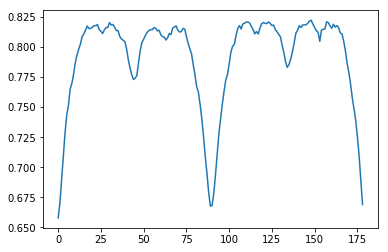

In [9]:
# for a given dataset e.g.'set2', similarity between neighboring angles as a func of absolute orientations
# note that the features can come from different maxpool layers

# very specifically shows after the 1st maxpool layer!!!
# not the one before/after it

from itertools import count
from itertools import islice
pair_gen = zip(count(0), count(1))
cosSimilarity_ave = np.empty((179,1,))
set_ind = 21 #or 2~5, set_ind=11 for high noise level
for i,j in list(islice(pair_gen, 0, 179)):
#     print('%d'%i + ', ' + '%d'%j)
    ang1_ind = i
    ang2_ind = j
    cosSimilarity = np.empty((50,1,))
    for img_ind in np.arange(50):
        # load the 1st image
        image1 = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar1 = Variable(preprocessFn(image1).unsqueeze(0))
        features1 = feature_extractor(inputVar1)#alexnet.features(inputVar1)
        # load the 2nd image
        image2 = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar2 = Variable(preprocessFn(image2).unsqueeze(0))
        features2 = feature_extractor(inputVar2)#alexnet.features(inputVar2)
        # cosine similarity
        cosSimilarity[img_ind] = cosine_similarity(
            features1.data.numpy().reshape(1, -1),
            features2.data.numpy().reshape(1, -1)
        )
    cosSimilarity_ave[i] = np.mean(cosSimilarity)
    
plt.plot(np.arange(179),cosSimilarity_ave)
#outfile = 'alexnetfeatures1stMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind
#outfile = 'alexnetfeatures2ndMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind

#np.save(outfile, cosSimilarity_ave)

#outfile.seek(0) # Only needed here to simulate closing & reopening file
#np.load(outfile)

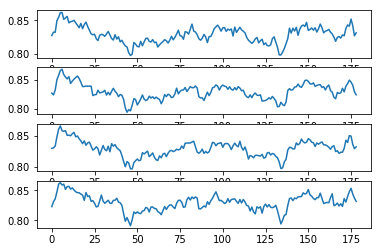

In [163]:
# alexnet.features - after the 3rd maxpool
set_ind = 5
outfile = 'alexnetfeatures_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
#outfile.seek(0) # Only needed here to simulate closing & reopening file
cosSimilarity_ave = np.load(outfile)
plt.subplot(4,1,1)
plt.plot(np.arange(179),cosSimilarity_ave)
set_ind = 4
outfile = 'alexnetfeatures_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
#outfile.seek(0) # Only needed here to simulate closing & reopening file
cosSimilarity_ave = np.load(outfile)
plt.subplot(4,1,2)
plt.plot(np.arange(179),cosSimilarity_ave)
set_ind = 3
outfile = 'alexnetfeatures_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
#outfile.seek(0) # Only needed here to simulate closing & reopening file
cosSimilarity_ave = np.load(outfile)
plt.subplot(4,1,3)
plt.plot(np.arange(179),cosSimilarity_ave)
outfile = 'alexnetfeatures_cosSimilarity_50samples.npy'
#outfile.seek(0) # Only needed here to simulate closing & reopening file
cosSimilarity_ave = np.load(outfile)
plt.subplot(4,1,4)
plt.plot(np.arange(179),cosSimilarity_ave)

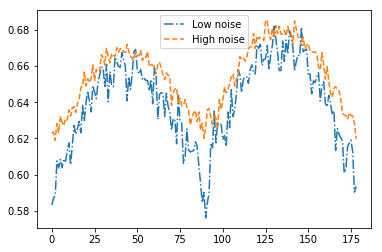

In [32]:
# after the 1st maxpool
set_ind = 5#low noise
outfile = 'alexnetfeatures1stMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
# outfile = 'alexnetfeatures2ndMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind
cosSimilarity_ave_lowNoise = np.load(outfile)
set_ind = 11#high noise
outfile = 'alexnetfeatures1stMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
cosSimilarity_ave_highNoise = np.load(outfile)
plt.plot(np.arange(179),cosSimilarity_ave_lowNoise, linestyle='-.', label='Low noise')
plt.plot(np.arange(179),cosSimilarity_ave_highNoise, linestyle='--', label='High noise')
plt.legend()

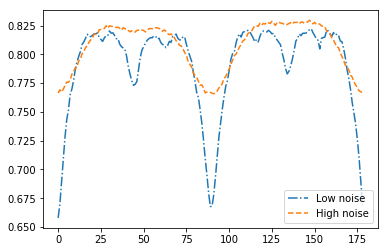

In [184]:
# after the 1st maxpool
set_ind = 21#low noise
outfile = 'alexnetfeatures1stMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
# outfile = 'alexnetfeatures2ndMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind
cosSimilarity_ave_lowNoise = np.load(outfile)
set_ind = 31#high noise
outfile = 'alexnetfeatures1stMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
cosSimilarity_ave_highNoise = np.load(outfile)
plt.plot(np.arange(179),cosSimilarity_ave_lowNoise, linestyle='-.', label='Low noise')
plt.plot(np.arange(179),cosSimilarity_ave_highNoise, linestyle='--', label='High noise')
plt.legend()

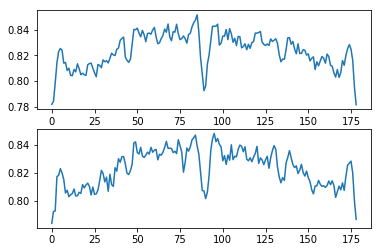

In [337]:
# after the 2nd maxpool
for set_ind in [4, 5]:
    plt.subplot(2,1,set_ind-3)
    outfile = 'alexnetfeatures2ndMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind + '.npy'
    # outfile = 'alexnetfeatures2ndMaxpool_cosSimilarity_50samples_set' + '%d'%set_ind
    cosSimilarity_ave = np.load(outfile)
    plt.plot(np.arange(179),cosSimilarity_ave)

# Look at the similarity in the image space

5.46993088722229


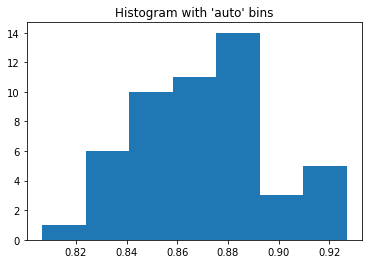

In [111]:
# cell to test how long it may take
ang1_ind = 0
ang2_ind = 160
cosSimilarity = np.empty((50,1,))
t1 = time.time()
for img_ind in np.arange(50):
    # load the 1st image
    image1 = Image.open('data/set2/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    # load the 2nd image
    image2 = Image.open('data/set2/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    # cosine similarity - image space
    cosSimilarity[img_ind] = cosine_similarity(
        np.array(image1.getdata()).reshape(1, -1),
        np.array(image2.getdata()).reshape(1, -1)
    )
print(time.time()-t1)
a = np.hstack(cosSimilarity)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

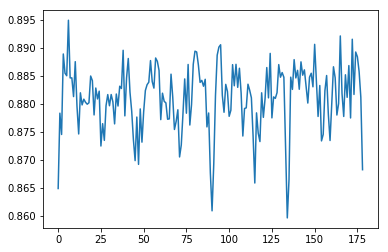

In [10]:
pair_gen = zip(count(0), count(1))
img_cosSimilarity_ave = np.empty((179,1,))
for i,j in list(islice(pair_gen, 0, 179)):
#     print('%d'%i + ', ' + '%d'%j)
    ang1_ind = i
    ang2_ind = j
    cosSimilarity = np.empty((50,1,))
    for img_ind in np.arange(50):
        # load the 1st image
        image1 = Image.open('data/set2/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        # load the 2nd image
        image2 = Image.open('data/set2/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        # cosine similarity - image space
        cosSimilarity[img_ind] = cosine_similarity(
            np.array(image1.getdata()).reshape(1, -1),
            np.array(image2.getdata()).reshape(1, -1)
        )
    img_cosSimilarity_ave[i] = np.mean(cosSimilarity)
# # save
# outfile = 'img_cosSimilarity_50samples'
# np.save(outfile, img_cosSimilarity_ave)

# visualize
plt.plot(np.arange(179),img_cosSimilarity_ave)

## Summary plot to show the response sensitivity at various feature spaces

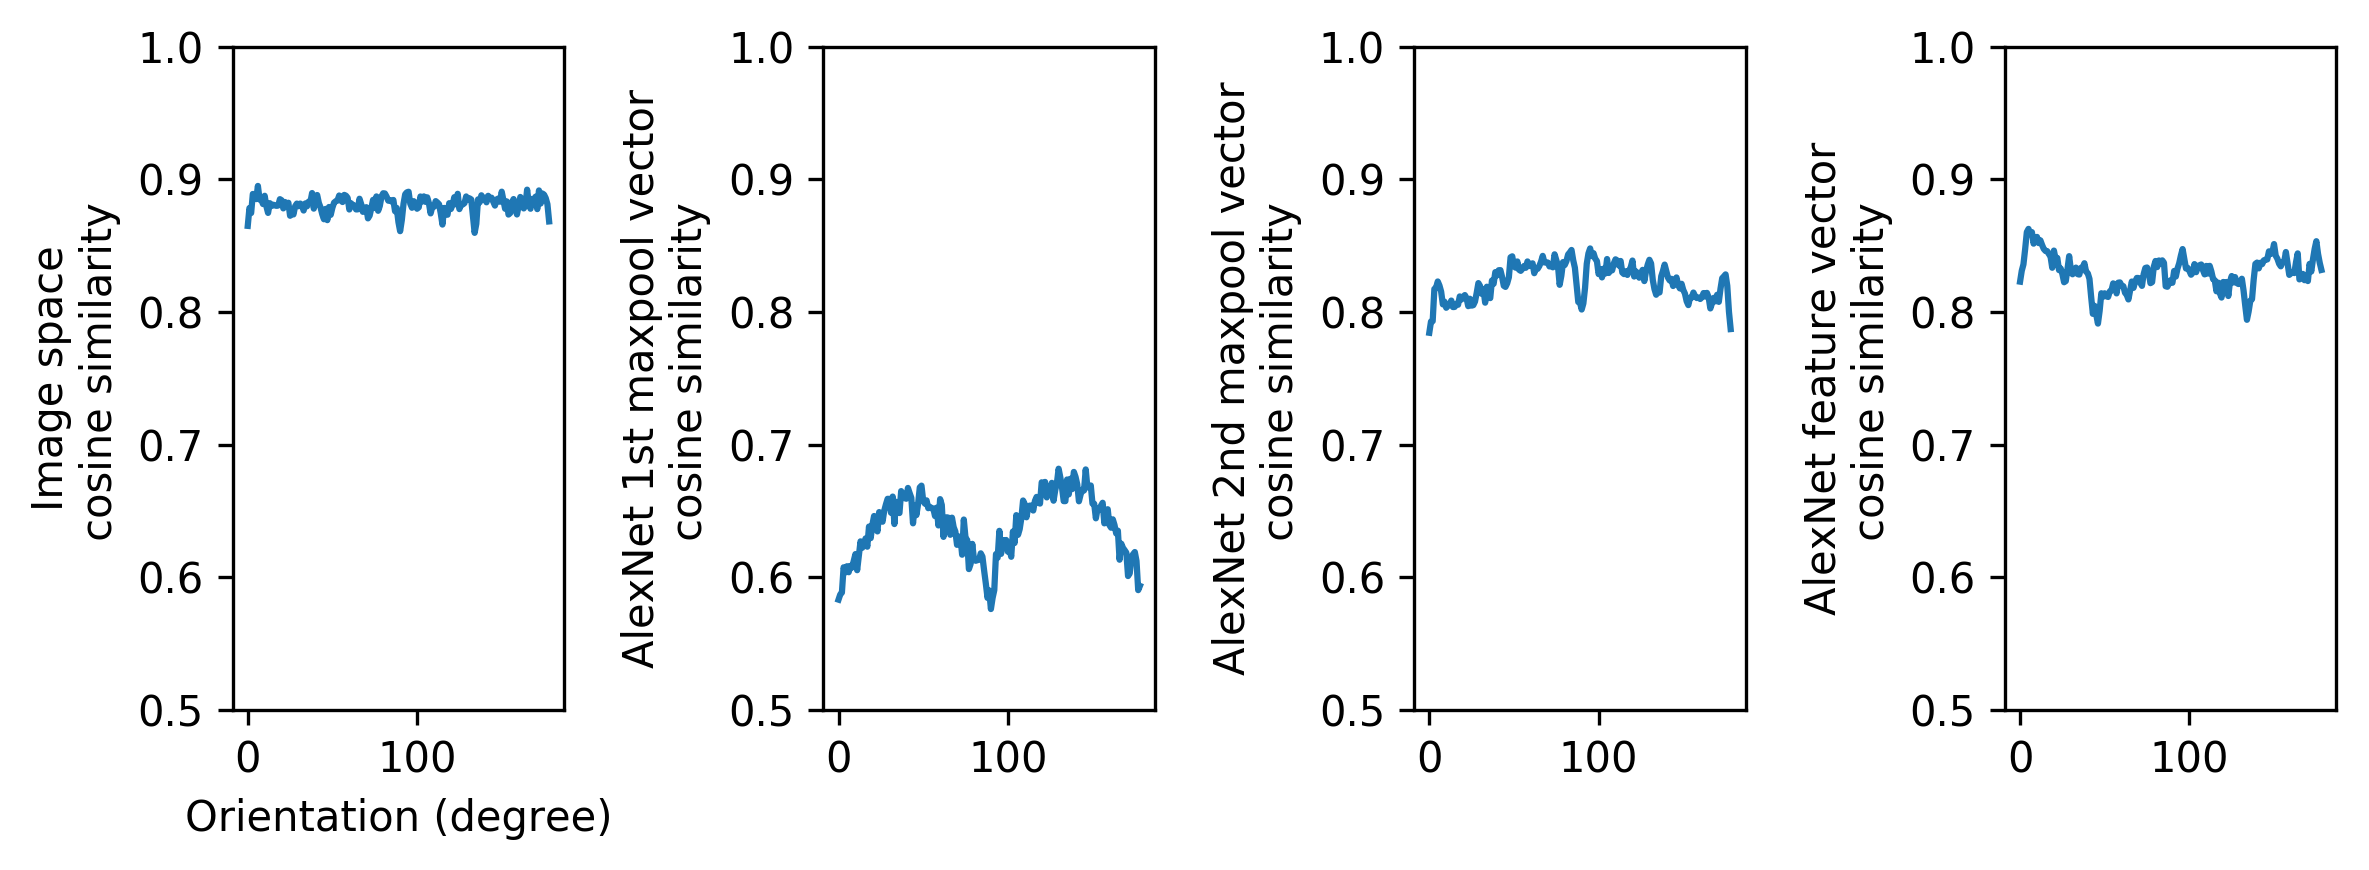

In [3]:
plt.figure(num=None, figsize=(8, 3), dpi=300, facecolor='w', edgecolor='k')

outfile = 'img_cosSimilarity_50samples.npy'
img_cosSimilarity_ave = np.load(outfile)
plt.subplot(1, 4, 1)
plt.plot(np.arange(179),img_cosSimilarity_ave)
plt.ylim(.5, 1)
plt.ylabel('Image space\n cosine similarity')
plt.xlabel('Orientation (degree)')

# 1st maxpool
outfile = 'alexnetfeatures1stMaxpool_cosSimilarity_50samples_set5.npy'
cosSimilarity_ave = np.load(outfile)
plt.subplot(1, 4, 2)
plt.plot(np.arange(179),cosSimilarity_ave)
plt.ylim(.5, 1)
# plt.gca().set_title('AlexNet feature vector\n cosine similarity')
plt.ylabel('AlexNet 1st maxpool vector\n cosine similarity')

# 2nd maxpool
outfile = 'alexnetfeatures2ndMaxpool_cosSimilarity_50samples_set5.npy'
cosSimilarity_ave = np.load(outfile)
plt.subplot(1, 4, 3)
plt.plot(np.arange(179),cosSimilarity_ave)
plt.ylim(.5, 1)
# plt.gca().set_title('AlexNet feature vector\n cosine similarity')
plt.ylabel('AlexNet 2nd maxpool vector\n cosine similarity')

# alexnet.feature
outfile = 'alexnetfeatures_cosSimilarity_50samples.npy'
cosSimilarity_ave = np.load(outfile)
plt.subplot(1, 4, 4)
plt.plot(np.arange(179),cosSimilarity_ave)
plt.ylim(.5, 1)
# plt.gca().set_title('AlexNet feature vector\n cosine similarity')
plt.ylabel('AlexNet feature vector\n cosine similarity')
plt.tight_layout()

# Look at the difference (cosine similarity) relative to a reference orientation


In [ ]:
ang1_ind = 0
ang2_ind = 90
imgDiff_cosSimilarity = np.empty((50,1,))
featDiff_cosSimilarity = np.empty((50,1,))
t1 = time.time()
for img_ind in np.arange(50):
    # load the 1st image
    image1 = Image.open('data/set2/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    inputVar1 =  Variable(preprocessFn(image1).unsqueeze(0))
    features1 = alexnet.features(inputVar1)
    # load the 2nd image
    image2 = Image.open('data/set2/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    inputVar2 =  Variable(preprocessFn(image2).unsqueeze(0))
    features2 = alexnet.features(inputVar2)
    # cosine similarity - feature space
    featDiff_cosSimilarity[img_ind] = cosine_similarity(
        features1.data.numpy().reshape(1, -1),
        features2.data.numpy().reshape(1, -1)
    )
    # cosine similarity - image space
    imgDiff_cosSimilarity[img_ind] = cosine_similarity(
            np.array(image1.getdata()).reshape(1, -1),
            np.array(image2.getdata()).reshape(1, -1)
        )
print(time.time()-t1)

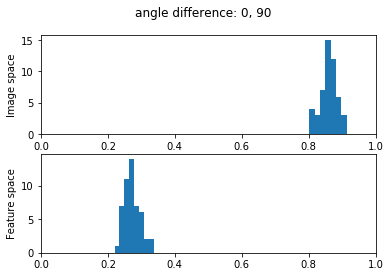

In [132]:
plt.subplot(211)
a = np.hstack(imgDiff_cosSimilarity)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.xlim(0, 1)
plt.ylabel('Image space')
plt.subplot(212)
a = np.hstack(featDiff_cosSimilarity)
plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.xlim(0, 1)
plt.ylabel('Feature space')
plt.suptitle('angle difference: ' + '%d'%ang1_ind + ', ' + '%d'%ang2_ind )
plt.show()

In [187]:
# loop through all angles, and compare with 0 deg
set_ind = 21 #or 2 for low noise 
# note that the reference is always low noise (set2) 0 or other angle
imgDiff_cosSimilarity_ave = np.empty((179,1,))
featDiff_cosSimilarity_ave = np.empty((179,1,))
ang1_ind = 0
for i in np.arange(0, 179, 1):#i+1    
#     print('%d'%i)
    ang2_ind = i + 1
    imgDiff_cosSimilarity = np.empty((50,1,))
    featDiff_cosSimilarity = np.empty((50,1,))
    for img_ind in np.arange(50):
        # load the 1st image
        image1 = Image.open('data/set2/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar1 =  Variable(preprocessFn(image1).unsqueeze(0))
        features1 = alexnet.features(inputVar1)
        # load the 2nd image
        image2 = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar2 =  Variable(preprocessFn(image2).unsqueeze(0))
        features2 = alexnet.features(inputVar2)
        # cosine similarity - feature space
        featDiff_cosSimilarity[img_ind] = cosine_similarity(
            features1.data.numpy().reshape(1, -1),
            features2.data.numpy().reshape(1, -1)
        )
        # cosine similarity - image space
        imgDiff_cosSimilarity[img_ind] = cosine_similarity(
            np.array(image1.getdata()).reshape(1, -1),
            np.array(image2.getdata()).reshape(1, -1)
        )
    imgDiff_cosSimilarity_ave[i] = np.mean(imgDiff_cosSimilarity)
    featDiff_cosSimilarity_ave[i] = np.mean(featDiff_cosSimilarity)
    
# # save
# np.savez('diff_relativeTo0_set' + '%d'%set_ind + '.npz', 
#          imgDiff=imgDiff_cosSimilarity_ave, featDiff=featDiff_cosSimilarity_ave)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178


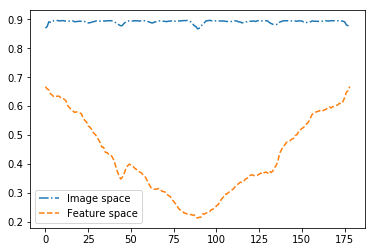

In [189]:
data = np.load('diff_relativeTo0_set21.npz')
plt.plot(np.arange(179),data['imgDiff'],linestyle='-.',label='Image space')
plt.plot(np.arange(179),data['featDiff'],linestyle='--',label='Feature space')
plt.legend()

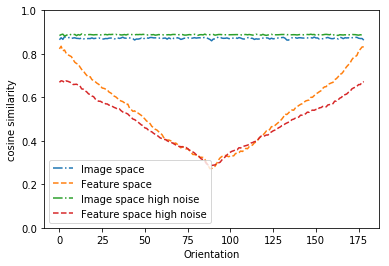

In [38]:
data = np.load('diff_relativeTo0_set2.npz')
plt.plot(np.arange(179),data['imgDiff'],linestyle='-.',label='Image space')
plt.plot(np.arange(179),data['featDiff'],linestyle='--',label='Feature space')
data2 = np.load('diff_relativeTo0_set11.npz')
plt.plot(np.arange(179),data2['imgDiff'],linestyle='-.',label='Image space high noise')
plt.plot(np.arange(179),data2['featDiff'],linestyle='--',label='Feature space high noise')
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Orientation')
plt.ylabel('cosine similarity')
plt.show()

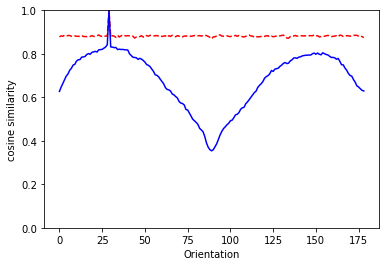

In [20]:
# visualize    
data = np.load('diff_relativeTo30_set2.npz')
plt.plot(np.arange(179),data['imgDiff'],'r--',np.arange(179),
         data['featDiff'],'b-')
plt.ylim(0, 1)
plt.xlabel('Orientation')
plt.ylabel('cosine similarity')
plt.show()
# so always most different from (absolute) 90 deg,
# not 90 deg off phase (orthogonal) to the reference angle

# data = np.load('diff_relativeTo0_set2.npz')
# print data['imgDiff']
# print data['featDiff']

In [197]:
# TODO: what if remove the bias effect when test & ref at the same noise level?? 

# method of adjustment
# given a high noise patch, find the low noise orientation that is most similar to it
ref_set_ind = 3 #low noise 
test_set_ind = 12 #high noise
# for each selected test (high noise) angle, go through all (0~90 deg) low noise orientations 
# to find the one that is closest to the test patch [results can only be integers, but better than nothing]
test_step = 5
test_angle = np.arange(0,91,test_step)#0:5:90
ref_angle = np.arange(0,91,1)

# also repeat for 50 samples
featDiff_cosSimilarity = np.empty((len(test_angle),len(ref_angle),50))

for img_ind in np.arange(50):
    for itest in test_angle:
        # load the test image
        test = Image.open('data/set' + '%d'%test_set_ind + '/ang_' + '%03d'%itest + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar2 = Variable(preprocessFn(test).unsqueeze(0))
        features2 = feature_extractor(inputVar2)#alexnet.features(inputVar2)
        for jref in ref_angle:
            ref = Image.open('data/set' + '%d'%ref_set_ind + '/ang_' + '%03d'%jref + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
            inputVar1 = Variable(preprocessFn(ref).unsqueeze(0))
            features1 = feature_extractor(inputVar1)#alexnet.features(inputVar1)

            # cosine similarity - feature space
            featDiff_cosSimilarity[int(itest/test_step),jref,img_ind] = cosine_similarity(
                features1.data.numpy().reshape(1, -1),
                features2.data.numpy().reshape(1, -1)
            )
    
# save
# outfile = 'method_adjustment_test' + '%d'%test_set_ind + '_ref%d'%ref_set_ind
outfile = 'method_adjustment_maxpool1_test' + '%d'%test_set_ind + '_ref%d'%ref_set_ind

np.save(outfile, featDiff_cosSimilarity)


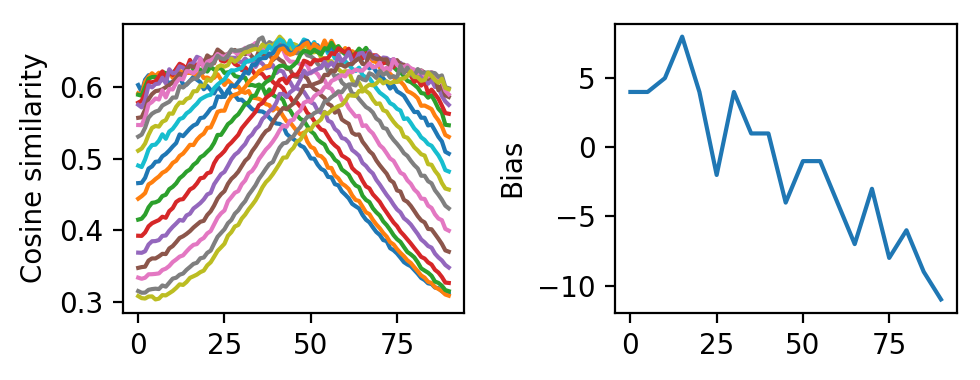

In [198]:
# directly show estimate bias based on the results from the last cell
plt.figure(num=None, figsize=(5, 2), dpi=200, facecolor='w', edgecolor='k')

# ref_set_ind = 2 #low noise 
# test_set_ind = 11 #high noise

# outfile = 'method_adjustment_test' + '%d'%test_set_ind + '_ref%d'%ref_set_ind + '.npy'
outfile = 'method_adjustment_maxpool1_test' + '%d'%test_set_ind + '_ref%d'%ref_set_ind + '.npy'

featDiff_cosSimilarity = np.load(outfile)

tmp = np.mean(featDiff_cosSimilarity,axis=2)
for itest in np.arange(0,np.size(tmp,0),):
    plt.subplot(1,2,1)
    plt.plot(ref_angle,tmp[itest,:])
plt.ylabel('Cosine similarity')

    
perceived_angle = np.empty(len(test_angle))
for itest in np.arange(0,np.size(tmp,0),):
    # find the max as predicted angle orientation (based on the feature vector)
    tmp_angle = np.unravel_index(np.argmax(tmp[itest,:], axis=None), tmp[itest,:].shape)
    perceived_angle[itest] = tmp_angle[0]

plt.subplot(1,2,2)
plt.plot(test_angle,perceived_angle-test_angle)
plt.ylabel('Bias')
plt.tight_layout()

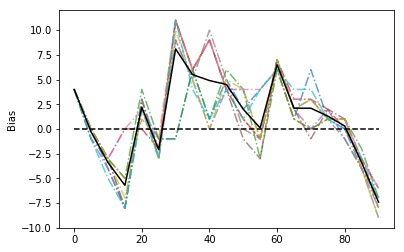

In [167]:
bias_ave = np.zeros(len(test_angle))
for ref_set_ind, test_set_ind in zip([2, 2, 2, 4, 3, 4, 4, 3, 3, 2], 
                                     [11, 12, 13, 13, 12, 12, 11, 11, 13, 14]):
    outfile = 'method_adjustment_test' + '%d'%test_set_ind + '_ref%d'%ref_set_ind + '.npy'
    featDiff_cosSimilarity = np.load(outfile)
    tmp = np.mean(featDiff_cosSimilarity,axis=2)
    perceived_angle = np.empty(len(test_angle))
    for itest in np.arange(0,np.size(tmp,0),):
        # find the max as predicted angle orientation (based on the feature vector)
        tmp_angle = np.unravel_index(np.argmax(tmp[itest,:], axis=None), tmp[itest,:].shape)
        perceived_angle[itest] = tmp_angle[0]

    plt.plot(test_angle,perceived_angle-test_angle,label='set'+'%d'%test_set_ind,linestyle='-.',alpha=0.7)
    bias_ave = bias_ave + (perceived_angle-test_angle)

#plt.legend()
plt.plot(test_angle,np.zeros(len(test_angle)),'k--')    
plt.plot(test_angle,bias_ave/10.0,'k-')
plt.ylabel('Bias')

In [149]:
(perceived_angle-test_angle).shape

(19,)

# What about features at different layers? - earlier feature layers


In [8]:
# construct a new feature extractor, as a sequential module, consisting of the first
# 6 layers of AlexNet (which are all arranged under alexnet.features)
feature_extractor = nn.Sequential(*list(alexnet.features.children())[:3])
#[:3] to stop at 1st maxpool
#[:6] to stop at 2nd maxpool
# inspect the layers
print(feature_extractor)

# use it to extract features.
feat1 = feature_extractor(Variable(preprocessFn(image2).unsqueeze(0))).data.numpy().reshape(1, -1)
feat2 = feature_extractor(Variable(preprocessFn(image1).unsqueeze(0))).data.numpy().reshape(1, -1)
cosine_similarity(feat1,feat2)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


array([[0.32734314]], dtype=float32)

In [298]:
feat1.shape

(1, 32448)

In [180]:
# loop through all angles, and compare with 0 deg
imgDiff_cosSimilarity_ave = np.empty((179,1,))
featDiff_cosSimilarity_ave = np.empty((179,1,))
ang1_ind = 0
for i in np.arange(0, 179, 10):#i+1    
    print('%d'%i)#for tracking progress
    ang2_ind = i + 1
    imgDiff_cosSimilarity = np.empty((50,1,))
    featDiff_cosSimilarity = np.empty((50,1,))
    for img_ind in np.arange(50):
        # load the 1st image
        image1 = Image.open('data/set2/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        features1 = feature_extractor(Variable(preprocessFn(image1).unsqueeze(0)))
        # load the 2nd image
        image2 = Image.open('data/set2/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        features2 = feature_extractor(Variable(preprocessFn(image2).unsqueeze(0)))
        # cosine similarity - feature space
        featDiff_cosSimilarity[img_ind] = cosine_similarity(
            features1.data.numpy().reshape(1, -1),
            features2.data.numpy().reshape(1, -1)
        )
    featDiff_cosSimilarity_ave[i] = np.mean(featDiff_cosSimilarity)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


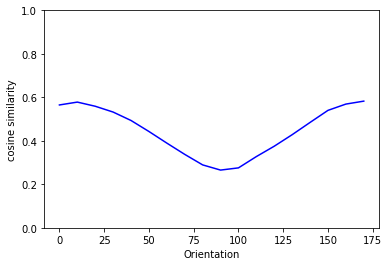

In [181]:
# visualize    
plt.plot(np.arange(0,179,10),featDiff_cosSimilarity_ave[np.arange(0,179,10)],'b-')
plt.ylim(0, 1)
plt.xlabel('Orientation')
plt.ylabel('cosine similarity')
plt.show()

# Feature embedding to 2d, try t-sne

In [11]:
from matplotlib import offsetbox

#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i, 0]),
                 color=plt.cm.Set1(y[i, 0] / 180.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#                 X[i])
#             ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [12]:
ang1_ind = 20
ang2_ind = 160
total_ind = 0
X = np.empty((100,9216,))
y = np.empty((100,1,))
for img_ind in np.arange(50):
    # load the 1st image
    image1 = Image.open('data/set4/ang_' + '%03d'%ang1_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    inputVar1 =  Variable(preprocessFn(image1).unsqueeze(0))
    features1 = alexnet.features(inputVar1)
    # load the 2nd image
    image2 = Image.open('data/set4/ang_' + '%03d'%ang2_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
    inputVar2 =  Variable(preprocessFn(image2).unsqueeze(0))
    features2 = alexnet.features(inputVar2)
    # feature vectors
    X[total_ind,:] = features1.data.numpy().reshape(1, -1)
    y[total_ind] = ang1_ind
    total_ind = total_ind + 1
    X[total_ind,:] = features2.data.numpy().reshape(1, -1)
    y[total_ind] = ang2_ind
    total_ind = total_ind + 1

n_samples, n_features = X.shape
n_neighbors = 30

Computing PCA projection


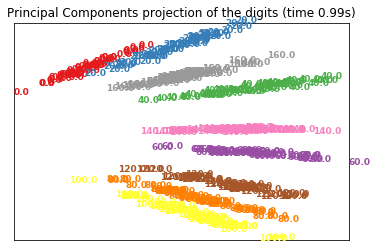

In [325]:
print("Computing PCA projection")
t0 = time.time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time.time() - t0))

In [324]:
# more angles
ang_ind_all = np.arange(0,179,20)
X = np.empty((len(ang_ind_all)*50,46656,))#9216, alexNet.feature; 46656 1st maxpool; 32448 2nd maxpool
y = np.empty((len(ang_ind_all)*50,1,))
total_ind = 0
for ang_ind in ang_ind_all:
    for img_ind in np.arange(50):
        img = Image.open('data/set4/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar = Variable(preprocessFn(img).unsqueeze(0))
        features = feature_extractor(inputVar)#alexnet.features(inputVar)
        # feature vectors
        X[total_ind,:] = features.data.numpy().reshape(1, -1)
        y[total_ind] = ang_ind
        total_ind = total_ind + 1


In [319]:
plt.cm.Set1

In [14]:
# from sklearn import (manifold, datasets, decomposition, ensemble,
#                      discriminant_analysis, random_projection)

# #----------------------------------------------------------------------
# # t-SNE embedding of the digits dataset
# print("Computing t-SNE embedding")
# tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
# t0 = time.time()
# X_tsne = tsne.fit_transform(X)
# plot_embedding(X_tsne,
#                "t-SNE embedding of the orientations (time %.2fs)" %
#                (time.time() - t0))

# plt.show()

Done. Stress: 1385713644.380783


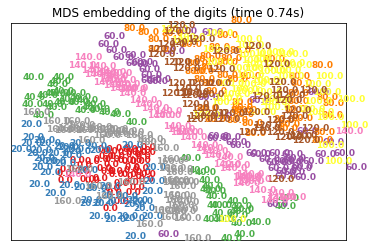

In [326]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time.time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time.time() - t0))

Computing PCA projection


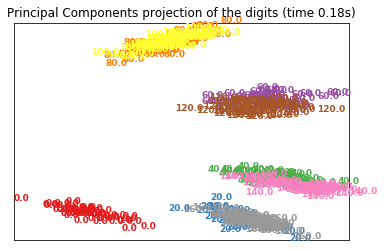

In [328]:
ang_ind_all = np.arange(0,179,20)
X = np.empty((len(ang_ind_all)*50,9216,))#9216, alexNet.feature; 46656 1st maxpool; 32448 2nd maxpool
y = np.empty((len(ang_ind_all)*50,1,))
total_ind = 0
for ang_ind in ang_ind_all:
    for img_ind in np.arange(50):
        img = Image.open('data/set4/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
        inputVar = Variable(preprocessFn(img).unsqueeze(0))
        features = alexnet.features(inputVar)
        # feature vectors
        X[total_ind,:] = features.data.numpy().reshape(1, -1)
        y[total_ind] = ang_ind
        total_ind = total_ind + 1
        
print("Computing PCA projection")
t0 = time.time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time.time() - t0))

## Response distribution given external noise

In [317]:
feature_extractor = nn.Sequential(*list(alexnet.features.children())[:3])
features_cat = []
ang_ind_all = [30]#np.arange(0,179,20)
for set_ind in [2, 3, 4, 5]:#[11, 12, 13, 14]:#[2, 3, 4, 5]:
    for ang_ind in ang_ind_all:
        for img_ind in np.arange(50):
            img = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
            inputVar = Variable(preprocessFn(img).unsqueeze(0))
            features = feature_extractor(inputVar)
            features_flat = features.data.numpy().reshape(1, -1)
            features_cat.append(features_flat)
all_features = np.vstack(features_cat)            

In [271]:
select_ind = np.int_(np.random.random((36,))*46656)
select_ind

array([26459,  8097, 37704,   285, 39562, 35638, 36965, 28218, 15682,
       46301, 45724, 31040, 24016, 33127, 39462, 41864, 30288, 27082,
       14176, 46378,  6166, 18501, 24865, 14987, 22855,   880, 24947,
        2182, 26192, 24725, 13198,  7535, 11377, 15584, 40254, 43252])

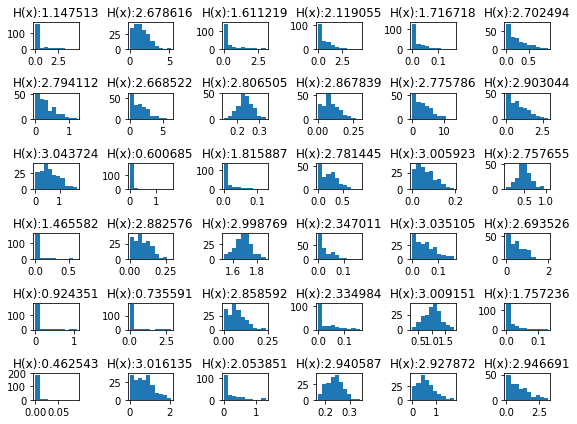

In [303]:
n_bins = 10
fig, axs = plt.subplots(6,6,figsize=(8, 6),)
for x in range(6):
    for y in range(6):
        # look at random components
        axs[x,y].hist(all_features[:,select_ind[x*6+y]], bins=n_bins)
        # calculate entropy
        hist, bin_edges = np.histogram(all_features[:,select_ind[x*6+y]], density=True)
        p_x = hist*np.diff(bin_edges)#need to remove 0
        p_x = p_x[p_x > 0.]
        entropy = -np.sum(p_x*np.log2(p_x))
        # title
        axs[x,y].set_title('H(x):%f'%entropy)#'%d'%select_ind[x*6+y] + 
        
plt.tight_layout()

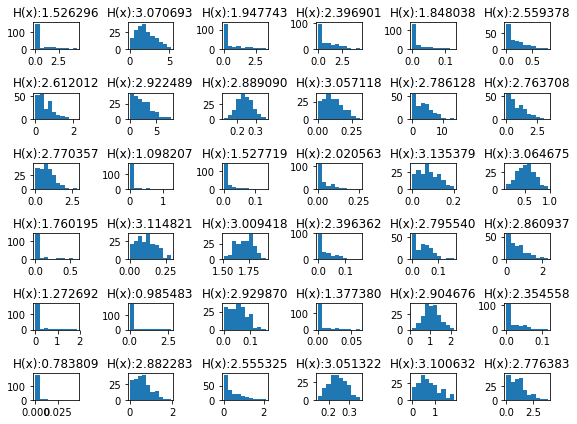

In [345]:
# example for a different angle
n_bins = 10
fig, axs = plt.subplots(6,6,figsize=(8, 6),)
for x in range(6):
    for y in range(6):
        # look at random components
        axs[x,y].hist(all_features[:,select_ind[x*6+y]], bins=n_bins)
        # calculate entropy
        hist, bin_edges = np.histogram(all_features[:,select_ind[x*6+y]], density=True)
        p_x = hist*np.diff(bin_edges)#need to remove 0
        #p_x = p_x[p_x > 0.]
        p_x[p_x == 0] = 1e-6
        entropy = -np.sum(p_x*np.log2(p_x))
        # title
        axs[x,y].set_title('H(x):%f'%entropy)#'%d'%select_ind[x*6+y] + 
        
plt.tight_layout()

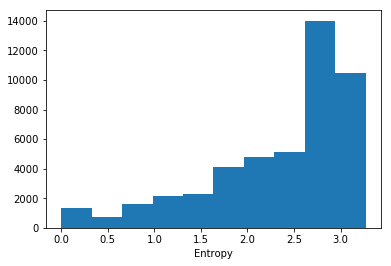

In [346]:
# here you use entropy to separate the units with mostly 0 response, 
# although the entropy could be similarly small if the unit intends to have a pulse respond 
# (invariant to external noise)

# entropy distribution 
all_entropy = []
for feature_ind in range(46656):
    hist, bin_edges = np.histogram(all_features[:,feature_ind], bins=10, density=True)
    p_x = hist*np.diff(bin_edges)
    #p_x = p_x[p_x > 0.]#remove 0
    p_x[p_x == 0] = 1e-6
    entropy = -np.sum(p_x*np.log2(p_x))
    all_entropy.append(entropy)
    
plt.hist(np.array(all_entropy))
plt.xlabel('Entropy')

In [321]:
# a function to extract empirical distribution for each ang_ind
# output all_features for calculating p_x and bin_edges, given each node
def extract_empirical_distribution(ang_ind,set_ind_all):
    # ang_ind = 30
    # set_ind_all = [2, 3, 4, 5]
    features_cat = []
    for set_ind in set_ind_all:#[11, 12, 13, 14]:#[2, 3, 4, 5]:
        for img_ind in np.arange(50):
            img = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
            inputVar = Variable(preprocessFn(img).unsqueeze(0))
            features = feature_extractor(inputVar)
            features_flat = features.data.numpy().reshape(1, -1)
            features_cat.append(features_flat)
    all_features = np.vstack(features_cat) 
    return all_features

In [328]:
import time
t1 = time.time()
test = extract_empirical_distribution(30,[2, 3, 4, 5])
print(time.time()-t1)

2.5175058841705322


In [409]:
import bisect
# get feature from a high noise image
set_ind, ang_ind, img_ind = 11, 30, 11
img = Image.open('data/set' + '%d'%set_ind + '/ang_' + '%03d'%ang_ind + '/img_ind_' + '%02d'%(img_ind+1) + '.png')
inputVar = Variable(preprocessFn(img).unsqueeze(0))
features = feature_extractor(inputVar)
features_flat = features.data.numpy().reshape(1, -1)
# empirical likelihood assuming independent notes
set_ind_all = [2, 3, 4, 5]
p_likelihood = np.zeros(180)
t1 = time.time()
for ang_ind in range(180):
    empirical_resps = extract_empirical_distribution(ang_ind,set_ind_all)
    for inode in range(46656):
        hist, bin_edges = np.histogram(empirical_resps[:,inode], bins=10, density=True)
        p_x = hist*np.diff(bin_edges)
        p_x[p_x == 0] = 1e-4
        entropy = -np.sum(p_x*np.log2(p_x))
        # only consider the node if the entropy is high?
        if entropy > 1.5:
            i = bisect.bisect_left(bin_edges, features_flat[0,inode])
            if i > len(p_x):
                i = len(p_x)
            elif i == 0:
                i = 1
            p_likelihood[ang_ind] = p_likelihood[ang_ind] + np.log(p_x[i-1])
print(time.time()-t1)            

2259.9398369789124


(-90000, -65000)

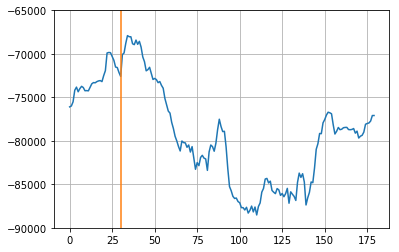

In [414]:
plt.plot(p_likelihood)
plt.plot([30, 30], [-90000, -65000])
plt.grid(True)
plt.ylim([-90000, -65000])

In [420]:
alexnet.state_dict()['features.0.weight'].shape

torch.Size([64, 3, 11, 11])

## alexnet features

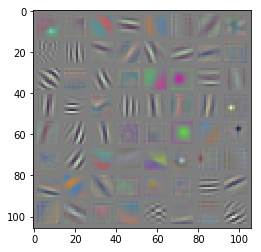

In [419]:
conv1_features = alexnet.state_dict()['features.0.weight']
# visualize features weights from conv layer1: [64, 3, 11, 11]
import torchvision
import torchvision.transforms as transforms
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(conv1_features))

In [423]:
features.shape

torch.Size([1, 64, 27, 27])